In [1]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
import glob
import h5py
import scipy.misc
import keras.backend as K

import skimage
from skimage.feature import hog
from skimage import data, color, exposure

Using TensorFlow backend.


In [2]:
plt.ion()
plt.show()

In [4]:
%pastebin 3

'https://gist.github.com/cec1e37af9744277db1721f343ae7f1a'

In [7]:
%recall


https://github.com/forcecore/Keras-GAN-Animeface-Character

In [3]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def make_hdf5(hdf5_name, wildcard, no_img, img_size):
    '''
    Preprocess files given by wildcard and save them in hdf5 file, as ofname.
    '''
    pool = list(glob.glob(wildcard))
    if no_img <= 0:
        fnames = pool
    else:
        fnames = []
        for i in range(no_img):
            # possible duplicate but don't care
            fnames.append(random.choice(pool))

    with h5py.File(hdf5_name, "w") as f:
        faces = f.create_dataset("faces", (len(fnames), img_size, img_size, 3), dtype='f')

        for i, fname in enumerate(fnames):
#             print(fname)
            im = scipy.misc.imread(fname, mode='RGB') # some have alpha channel
            im = scipy.misc.imresize(im, (img_size, img_size))
            faces[i] = normalize(im)

In [4]:
make_hdf5("data/faces.hdf5", "data/lfw_funneled/*/*.jpg", -1, 64)

In [5]:
f = h5py.File( "data/faces.hdf5", 'r' )
faces = list(f.get( 'faces' ))

In [6]:
len(list(faces))

13233

(64, 64, 3)


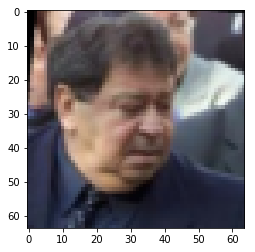

(64, 64)


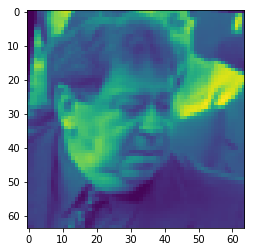

In [21]:
random_id = random.choice(range(len(list(faces))))
print(faces[random_id].shape)
plt.imshow(faces[random_id])
plt.show()
grey = color.rgb2gray(faces[random_id])
print(grey.shape)
# gray = cv.cvtColor(faces[random_id], cv.COLOR_BGR2GRAY)
plt.imshow(grey)
# plt.imshow(faces[random_id])


In [15]:
grey = color.rgb2gray(faces[random_id])
fd, hog_image = hog(grey, orientations=8, pixels_per_cell=(4, 4),cells_per_block=(1, 1), visualise=True, block_norm='L2-Hys')

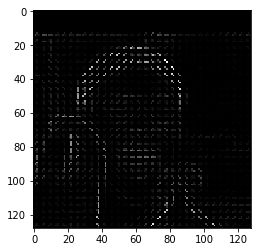

In [16]:
plt.imshow(hog_image, cmap=plt.cm.gray)

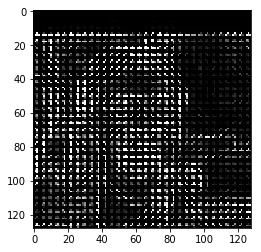

In [17]:
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 0.02))
plt.imshow(hog_image_rescaled, cmap=plt.cm.gray)

In [22]:
def getInputImages(ids):
    data = [faces[i] for i in  ids]
    data = np.stack(data)
    return data

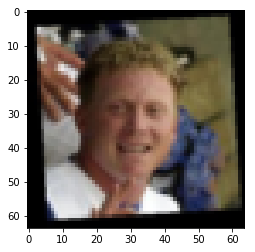

In [23]:
plt.imshow(getInputImages([1])[0])

In [24]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 1 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)
        

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [25]:
img_size = 64
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [26]:

def residual_block(y, nb_channels, _strides=(3, 3), _project_shortcut=False):
    shortcut = y

    # down-sampling is performed with a stride of 2
    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=_strides, padding='same')(y)
    y = BatchNormalization()(y)
    y = LeakyReLU()(y)

    y = Conv2D(nb_channels, kernel_size=(3, 3), strides=(1, 1), padding='same')(y)
    y = BatchNormalization()(y)

    # identity shortcuts used directly when the input and output are of the same dimensions
    if _project_shortcut or _strides != (1, 1):
        # when the dimensions increase projection shortcut is used to match dimensions (done by 1×1 convolutions)
        # when the shortcuts go across feature maps of two sizes, they are performed with a stride of 2
        shortcut = Conv2D(nb_channels, kernel_size=(1, 1), strides=_strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    y = keras.layers.add([shortcut, y])
    y = LeakyReLU()(y)

    return y

In [27]:
K.clear_session()
def build_generator():

    noise_shape = (100,)
    noise = Input(shape=noise_shape)
    depth = 128
    dim = 8

    x = Dense(dim * dim *depth, activation='tanh', input_shape=noise_shape)(noise)
    x = BatchNormalization(momentum=0.9)(x)

    x = Reshape((dim, dim, depth))(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(int(depth/2), 5, padding='same', activation='tanh')(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(int(depth/2), 5, padding='same', activation='tanh')(x)
    
#     x = UpSampling2D((2,2))(x)
#     x = Convolution2D(int(depth/2), 5, padding='same', activation='tanh')(x)
    
    x = UpSampling2D((2,2))(x)
    x = Convolution2D(3, 5, padding='same', activation='tanh')(x)
    

    model = Model(noise, x)


#     model.compile(optimizer=RMSprop(lr=0.0002, decay=6e-8), loss='binary_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return Model(noise, x)

generator = build_generator()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8192)              827392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8192)              32768     
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        204864    
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [28]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    depth = 64
    x = Convolution2D(depth, (5, 5), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

    
    x = residual_block(x, depth *2, _strides=(1, 1), _project_shortcut=False)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)

    x = residual_block(x, depth *4, _strides=(3, 1), _project_shortcut=False)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = Dropout(0.6)(x)

    x = Flatten(input_shape=img_shape)(x)

    x = LeakyReLU(alpha=0.2)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(input_img, x)

    model.compile(optimizer=Adam(lr=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
#     model.compile(optimizer=RMSprop(lr=0.0001, decay=3e-8), loss='binary_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_4 (Conv2D)                (None, 64, 64, 64)    4864        input_2[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 32, 32, 64)    0           conv2d_4[0][0]                   
____________________________________________________________________________________________________
conv2d_5 (Conv2D)                (None, 11, 11, 128)   73856       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [29]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [30]:
def getData(size):
    idx = list(np.random.randint(0, len(faces), size))

    imgs = getInputImages(idx)
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

    d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)

    return d_input, d_output
    

In [31]:
getData(2)
1

1

In [1]:
# half_batch = 2
# for epoch in range(100):

#     d_input, d_output = getData(half_batch)
#     discriminator.fit(d_input, d_output, epochs = 1)
#     pred1 = discriminator.predict(d_input)

    
#     t_input, t_output = getData(2)

#     pred = (discriminator.predict(t_input) > 0.5).astype(int)

#     print('accuracy_score : ' , accuracy_score(pred, t_output))


<IPython.core.display.Javascript object>


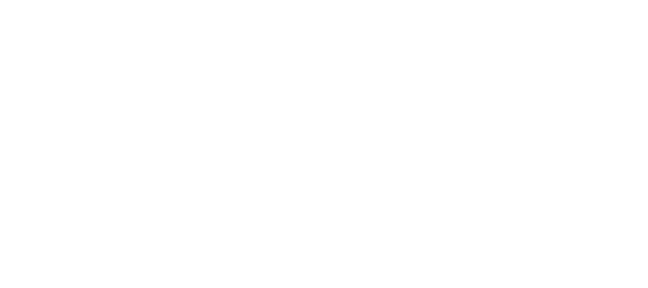

<IPython.core.display.Javascript object>


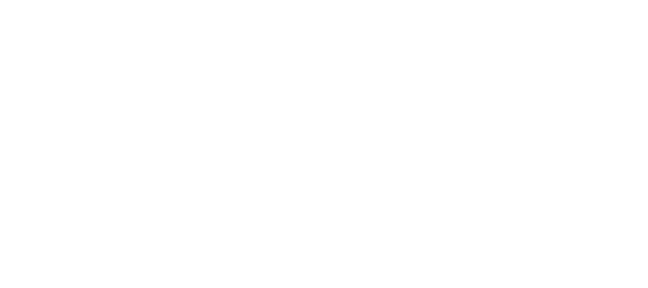

In [33]:
%matplotlib notebook
accuracyFig = plt.figure(figsize=(9,4))
accuracyFig.clf()

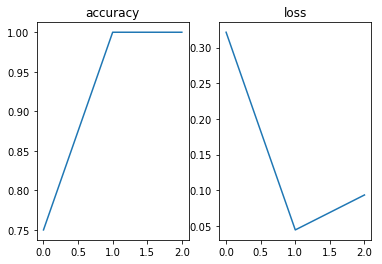

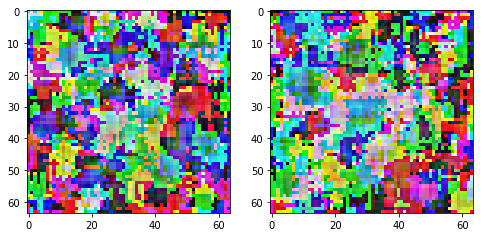

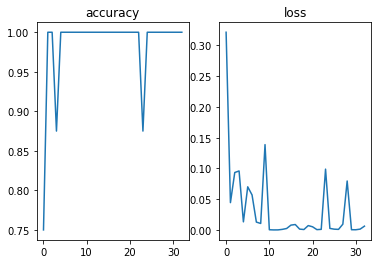

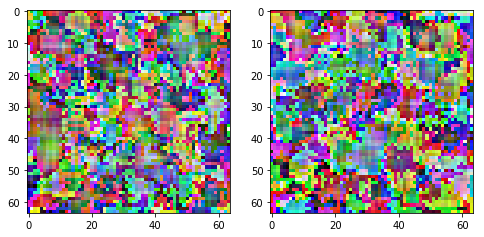

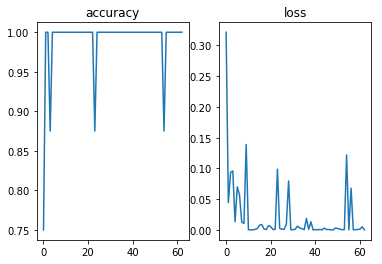

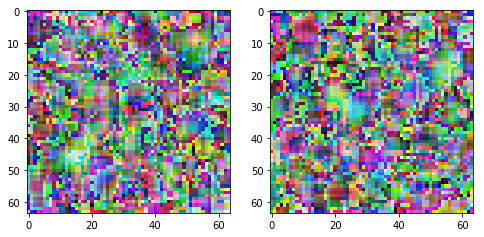

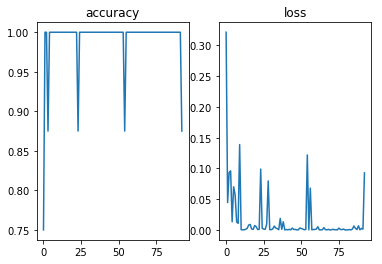

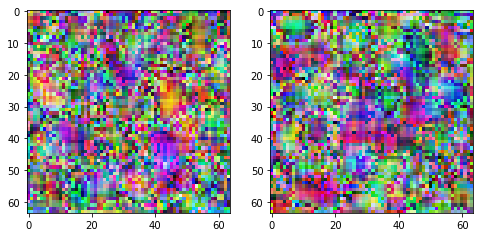

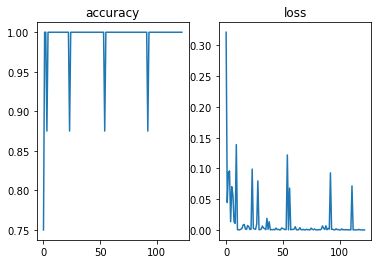

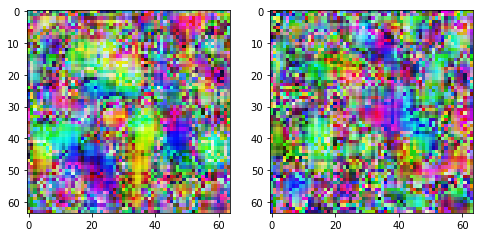

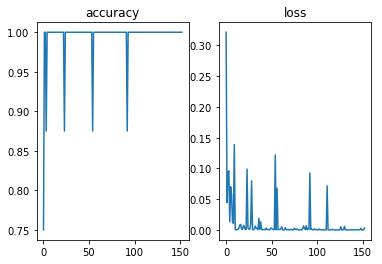

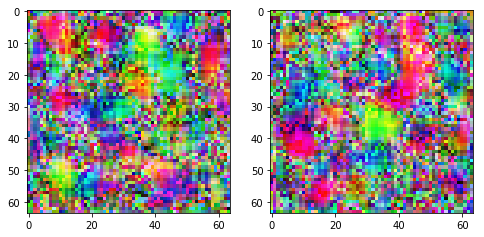

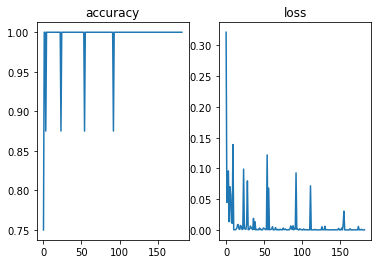

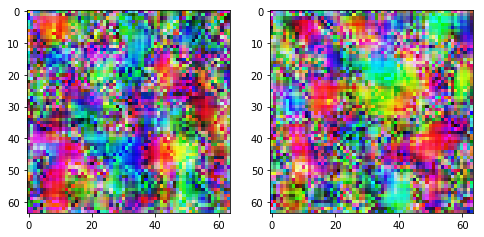

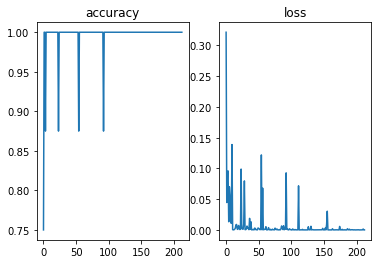

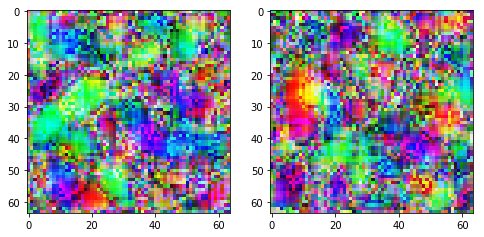

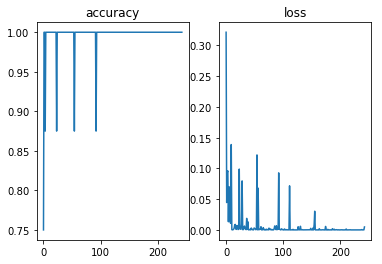

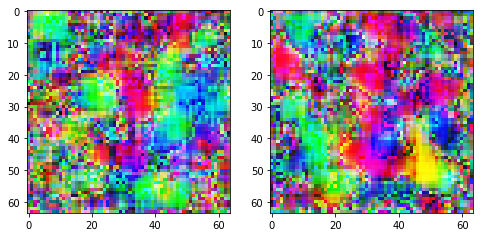

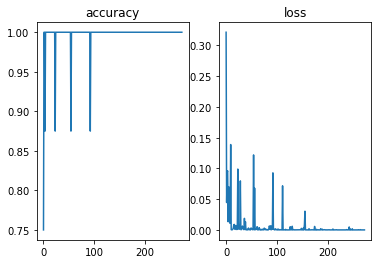

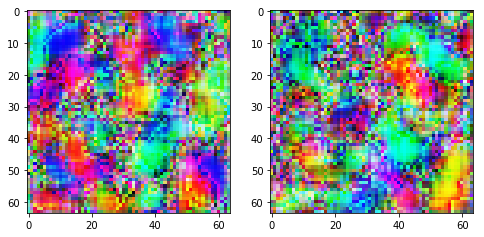

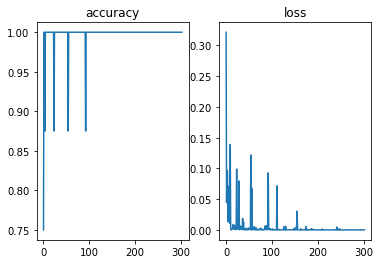

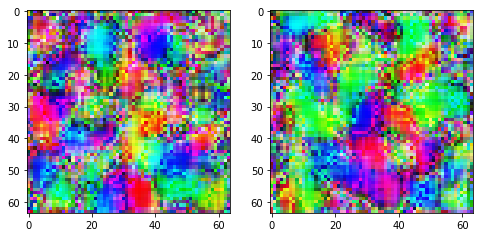

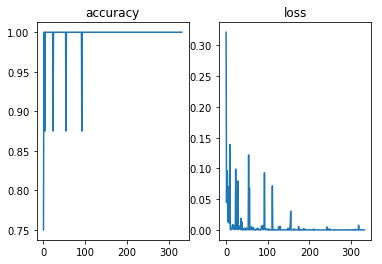

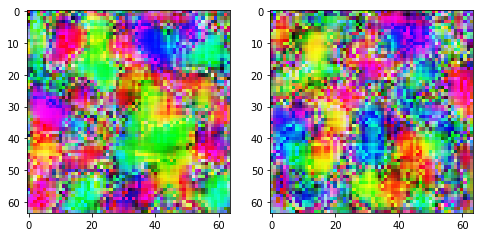

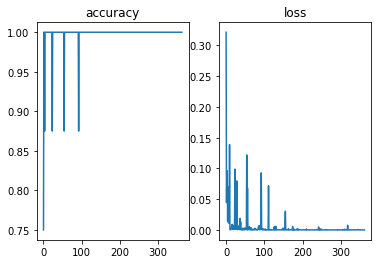

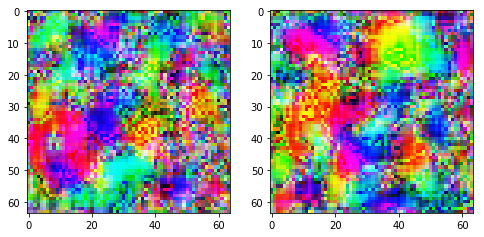

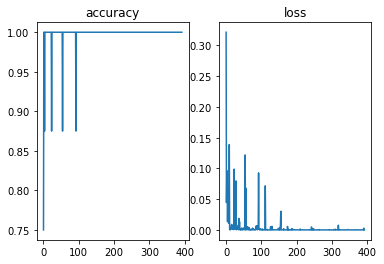

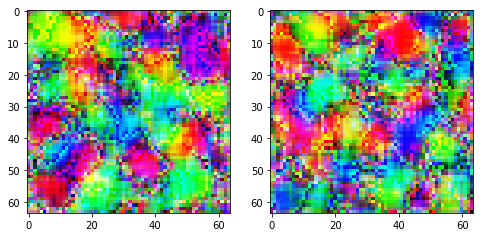

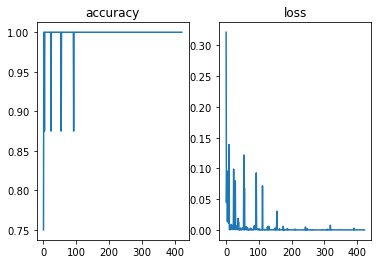

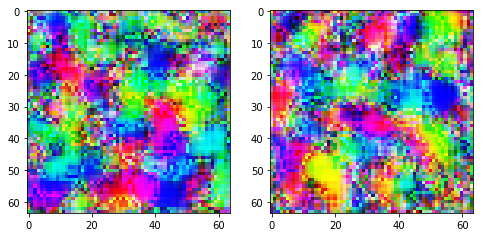

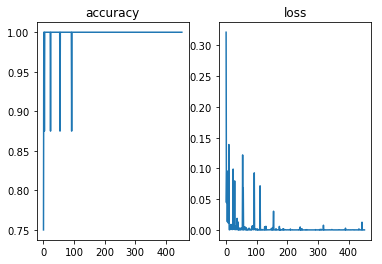

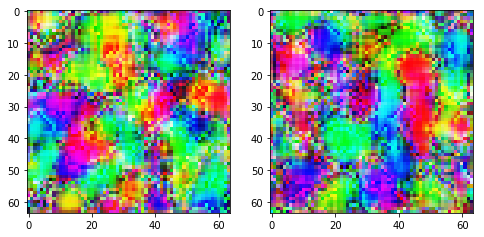

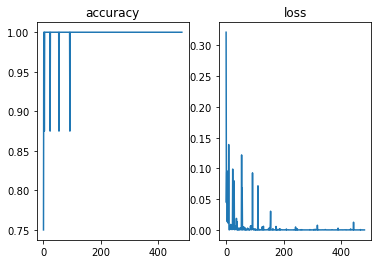

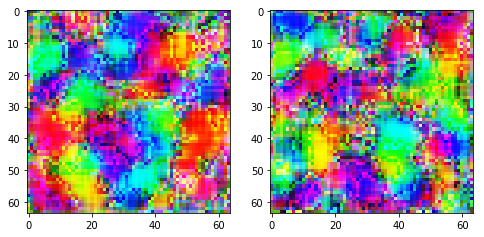

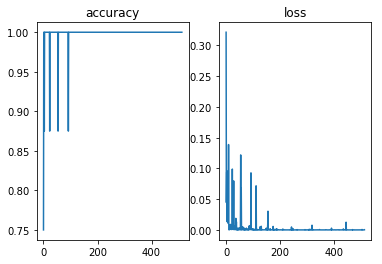

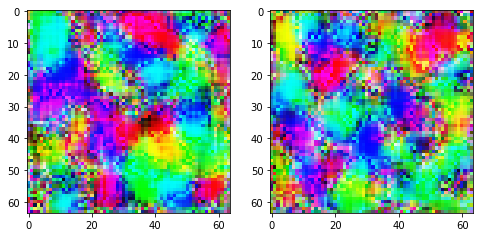

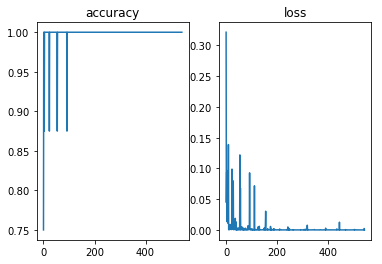

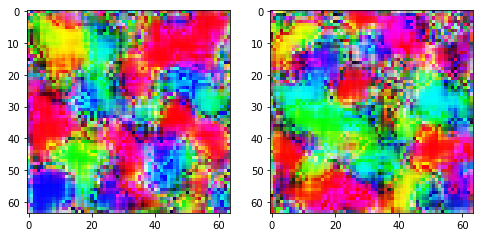

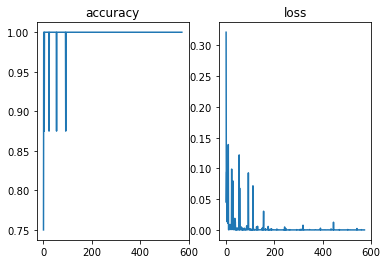

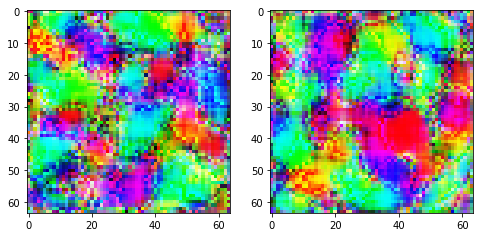

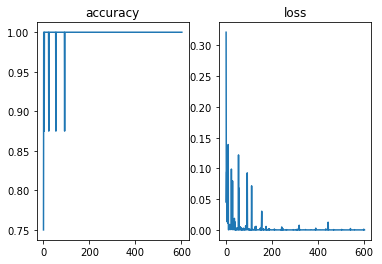

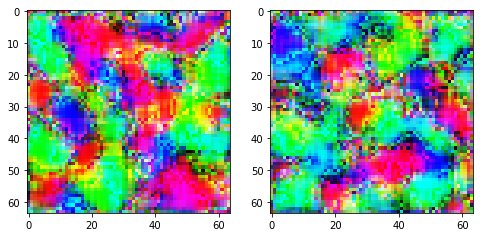

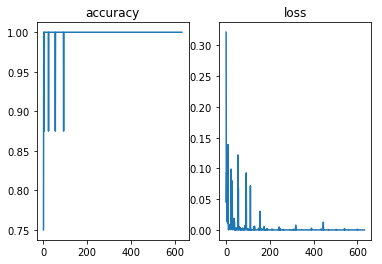

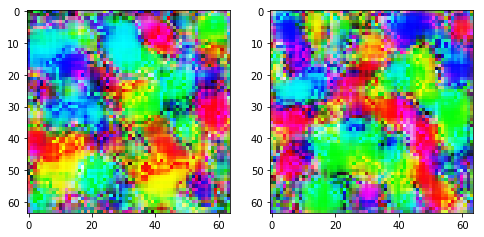

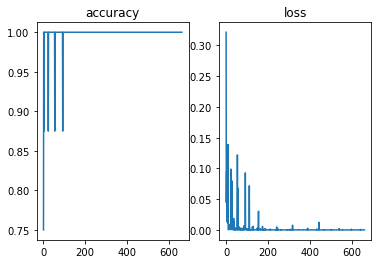

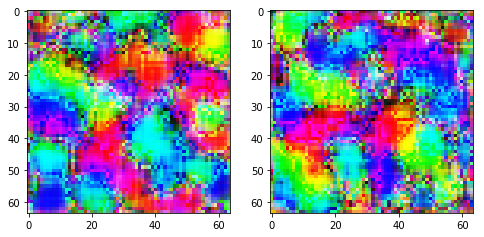

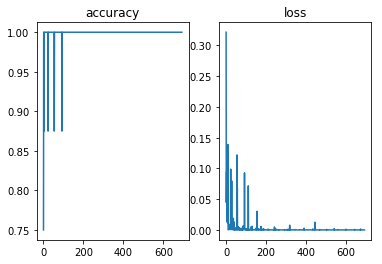

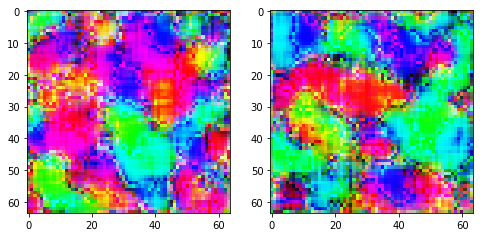

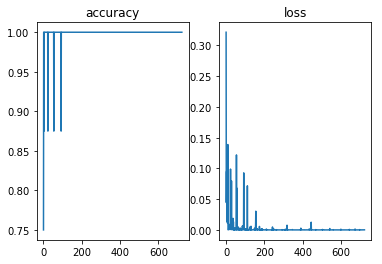

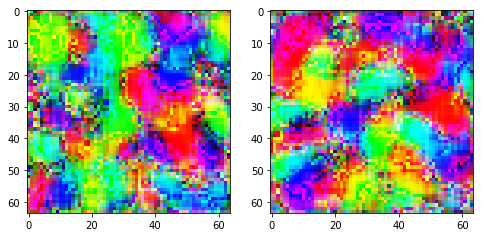

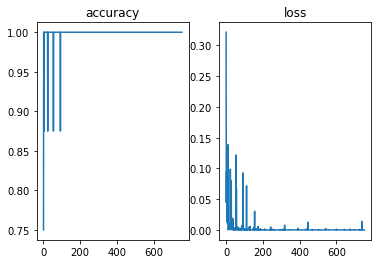

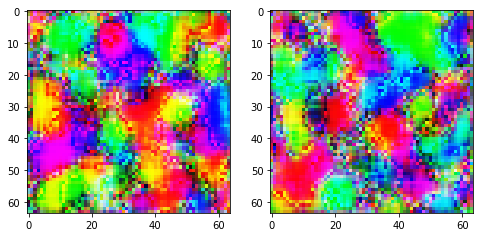

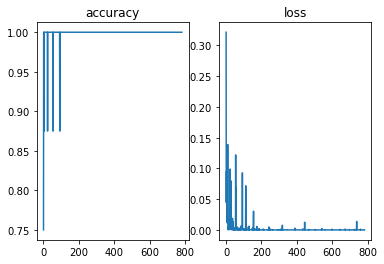

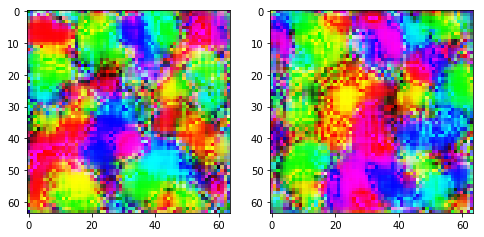

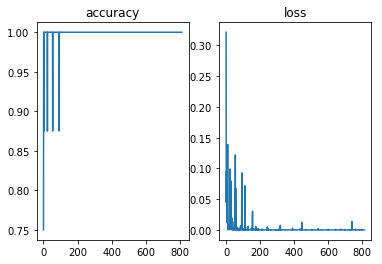

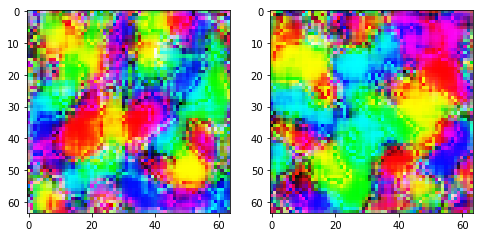

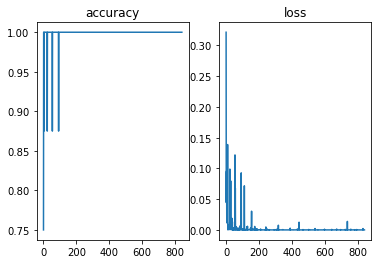

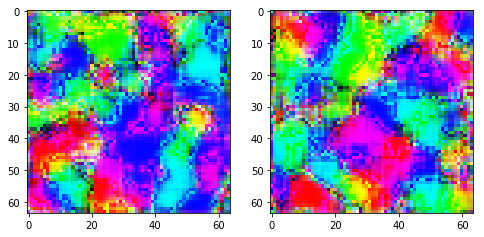

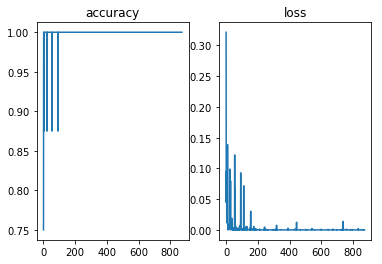

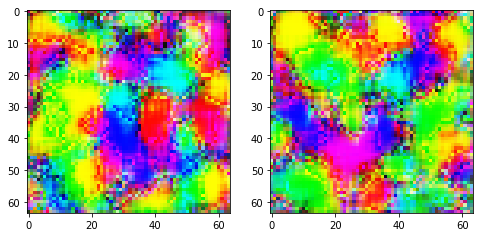

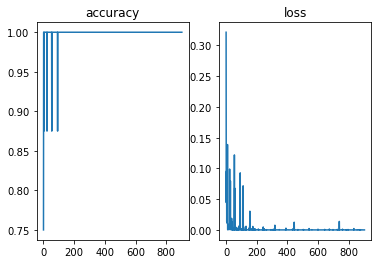

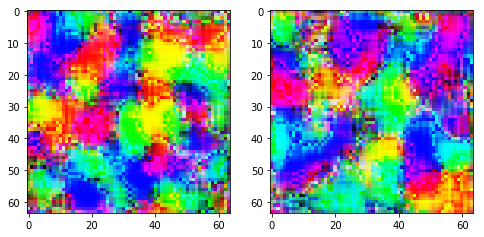

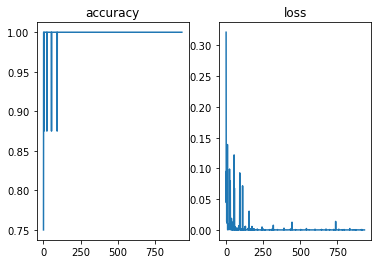

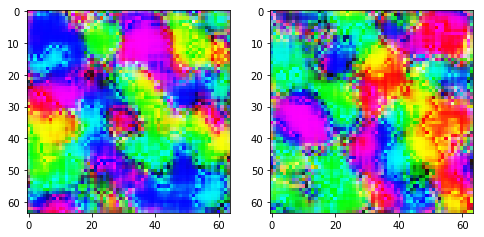

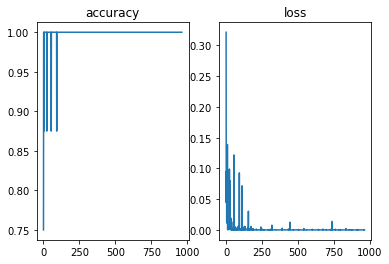

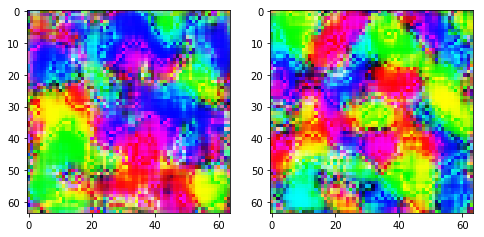

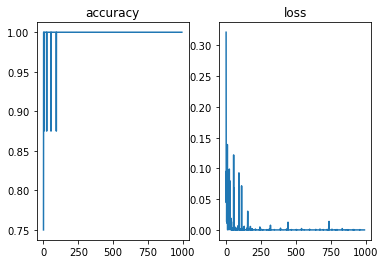

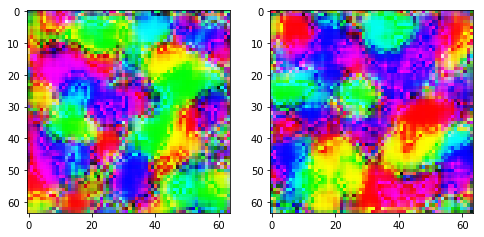

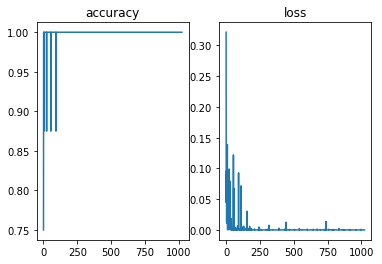

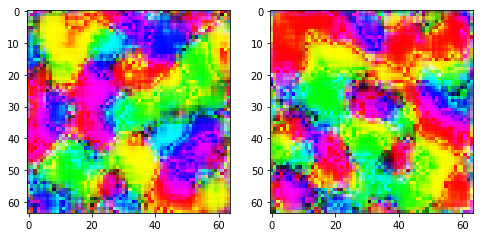

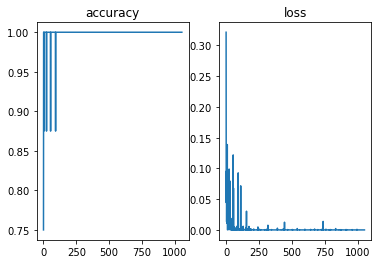

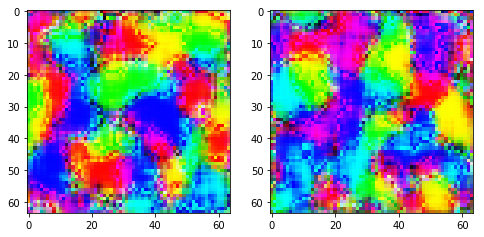

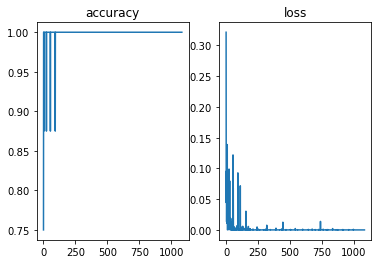

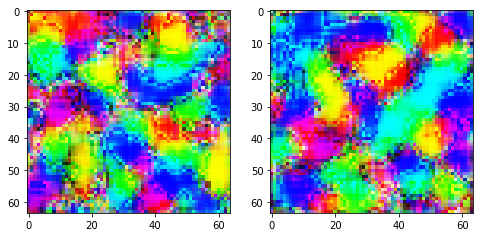

KeyboardInterrupt: 

In [34]:
# %matplotlib notebook
%matplotlib inline

epochs = 20000
batch_size = 8
save_interval= 10
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
acc = []
loss = []

img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
# combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=10, min_lr=0.001)
    #myPlot
    h = discriminator.fit(d_input, d_output, epochs = 3, verbose=0, callbacks=[reduce_lr])
    acc.extend(h.history.get('acc'))
    loss.extend(h.history.get('loss'))
#     print('history : ', h.history)

    
    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
#     print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        plt.figure(accuracyFig.number)
        plt.subplot(1,2,1)
        plt.plot(acc, label="accuracy")
        plt.title('accuracy')
        plt.subplot(1,2,2)
        plt.title('loss')
        plt.plot(loss, label="loss")
        accuracyFig.canvas.draw()
#         plt.show()
        save_imgs(epoch)